In [ ]:
import sys
import taffmat

#import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from data_utils import plot_data

# Importing Data

## Define Data Folders

In [ ]:
parent_data_folder = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
TEAC_raw_data_folder = parent_data_folder + "/TEAC/Raw Data/"
TEAC_test_name = "LX20_001"

TEAC_raw_url = TEAC_raw_data_folder + TEAC_test_name

TEAC_raw_url = "Y:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data/Field Visit 3 - July 26/Station 1/TEAC/raw data/LX10_001"

## Read and Import Data

In [ ]:
# read_taffmat returns tuple containing three elements: a 2D NumPy array, a 1D NumPy array, and an OrderedDict with metadata
# 4.1 GB → 49.1 s
test_raw_data = taffmat.read_taffmat(TEAC_raw_url)

In [ ]:
#data_channels = np.transpose(test_raw_data[0])
#data_time = test_raw_data[1].reshape((len(test_raw_data[1]), 1)).reshape(-1, 1)
data_combined = np.hstack((test_raw_data[1].reshape((len(test_raw_data[1]), 1)).reshape(-1, 1), np.transpose(test_raw_data[0])))

# Clear memory
del test_raw_data

## Shape into Dataframe

In [ ]:
# create a dictionary from the arrays
column_names = np.array(['time', 'CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8',
                         'CH9', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 
                         'CH16'])

# Station 1: 16 channels
## Channels 1-12: Accelerometers (4x)
## Channels 13-14: IRIG-B & 1-PPS

# Create a DataFrame from the numpy array with the specified column headers
data_frame = pd.DataFrame(data_combined, columns=column_names)

# Clear memory
del data_combined

In [7]:
#cols_to_drop = ['CH' + str(i) for i in range(9, 16)]
#cols_to_drop = ['CH' + str(i) for i in range(9, 16)]
#data_frame.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
# Export df to CSV [OPTIONAL]
#data_frame.to_csv(TEAC_raw_url + '.csv', index=False)

In [43]:
# Export df to .h5 [OPTIONAL]
# 4.1 GB → 18.7 GB (2 min)
data_frame.to_hdf(TEAC_raw_url + '.h5', key='df', mode='w')

# Meta Validation

### Maximum, minimums and average

In [35]:
# Calculate the maximum, minimum, and average values
max_values = data_frame.max()
min_values = data_frame.min()
average_values = data_frame.mean()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Maximum': max_values, 'Minimum': min_values, 'Average': average_values})

# Round the values to 1 decimal place
stats_df_rounded = stats_df.round(1)

# Display the results in a tabular format
print(stats_df_rounded)

# Note: values of 0.0 indicate that - most likely - the channel was not used

      Maximum  Minimum  Average
time  10003.1      0.0   5001.5
CH1       0.3     -0.3      0.0
CH2       0.5     -0.5      0.0
CH3       0.7     -0.8      0.0
CH4       0.4     -0.4      0.0
CH5       0.9     -1.0      0.0
CH6       0.9     -0.9      0.0
CH7       0.7     -0.8     -0.0
CH8       0.9     -0.8      0.0
CH9       0.0     -0.0     -0.0
CH10     -0.0     -0.0     -0.0
CH11     -0.0     -0.0     -0.0
CH12     -0.0     -0.0     -0.0
CH13      1.2     -4.8     -1.6
CH14      4.9     -0.7     -0.0
CH15     -0.0     -0.0     -0.0
CH16      0.0     -0.0     -0.0


### Data Points & Recording Time

In [38]:
# Access the first column using its index and count the number of data points
time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 120036992
Data was recorded for 10003.08 seconds
Data was recorded for 166.72 minutes
Data was recorded for 2.78 hours


### Sampling rate, Consistency and CV

In [37]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 12000  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")

Expected sampling rate: 12000 Hz
Effective sampling rate: 12000.00 Hz
Number of time intervals exceeding 5.0% deviation: 0
Percentage of time intervals exceeding 5.0% deviation: 0.00%


# Signal

### Accelerometer 1

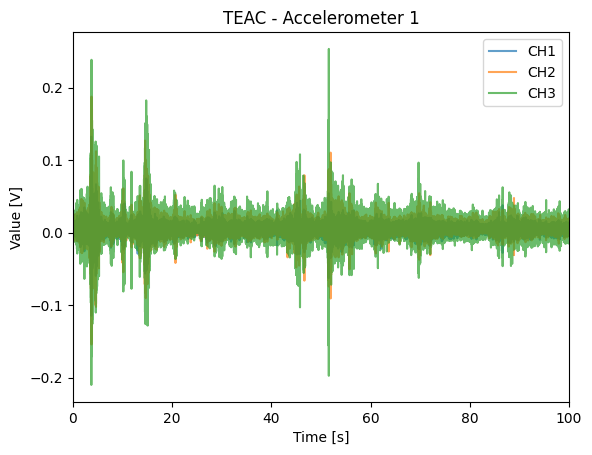

In [40]:
# 16 min data → 21.6 sec
plot_data(data_frame, ["CH1","CH2","CH3"], start_time=0, end_time=100, transparency=0.7, title = "TEAC - Accelerometer 1")

### Accelerometer 2

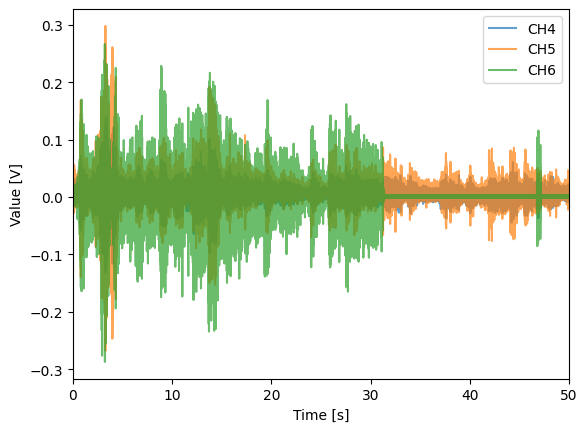

In [41]:
plot_data(data_frame, ["CH4","CH5","CH6"], start_time=0, end_time=50, transparency=0.7)

### Accelerometer 3

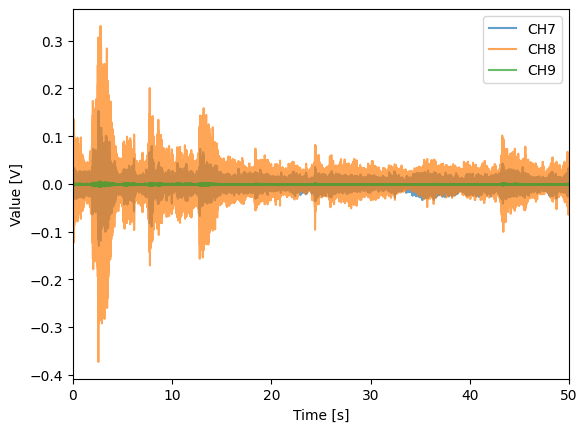

In [42]:
plot_data(data_frame, ["CH7","CH8","CH9"], start_time=0, end_time=50, transparency=0.7)

### Accelerometer 4

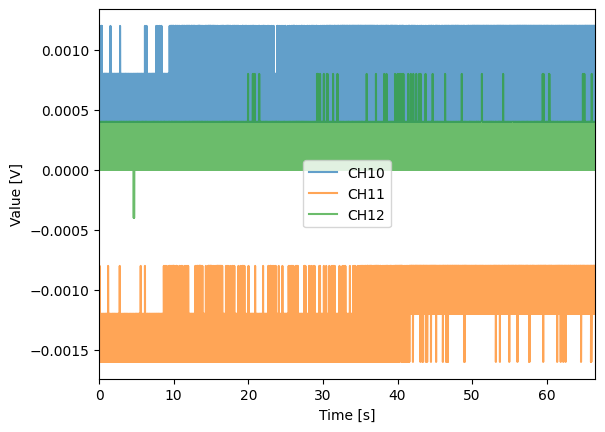

In [16]:
plot_data(data_frame, ["CH10","CH11","CH12"], start_time=0, end_time=None, transparency=0.7)
# Empty for the upcoming field test

### Accelerometer 1 - 4

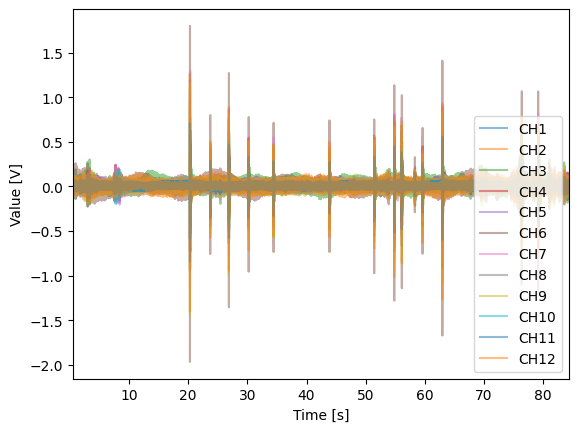

In [17]:
plot_data(data_frame, ["CH1","CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8", "CH9", "CH10", "CH11", "CH12"], start_time=0.5, end_time=None, transparency=0.5)

### IRIG & 1-PPS

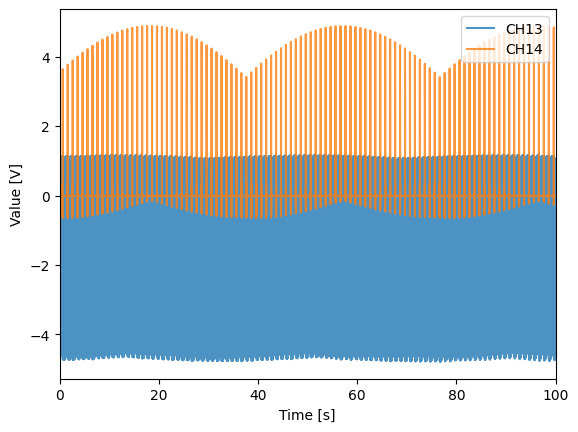

In [39]:
plot_data(data_frame, ["CH13", "CH14"], start_time=0, end_time=100, transparency=0.8)